# 시계열 2차시 실습
## 🌞 태양 흑점 데이터 시계열 모델 비교 실습

> **목표**: 다양한 시계열 분석 모델을 흑점 데이터에 적용하고, 각 모델의 적합성을 평가합니다.

**학습 목표:**
1. 전처리된 데이터를 불러와 모델링 준비
2. 다양한 시계열 모델 (ARIMA, SARIMA, Exponential Smoothing, 단순 모델 등) 적용
3. 각 모델의 예측 성능 비교 및 적합성 평가
4. 데이터 특성에 맞는 최적 모델 선정

---

## 0. 환경 설정

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
else:
    plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

# 시계열 분석 라이브러리
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


---

## 1. 데이터 로드 및 준비

이전 실습에서 전처리한 데이터를 불러옵니다.

In [3]:
# 원본 데이터 로드
data = pd.read_csv('sunspots_original.csv', index_col='YEAR', parse_dates=['YEAR'])

# ✅ 주파수 명시적 설정 (연간 데이터, 1월 시작)
data = data.asfreq('YS')

# 차분 데이터 로드 (assignment에서 저장한 1차+계절 차분 데이터)
data_diff_seasonal = pd.read_csv('sunspots_diff_seasonal.csv', parse_dates=['YEAR'])
data_diff_seasonal.set_index('YEAR', inplace=True)

# ✅ 차분 데이터에도 주파수 설정
data_diff_seasonal = data_diff_seasonal.asfreq('YS')

# 1차 차분 데이터도 생성 (ACF/PACF 비교용)
data_diff = data['SUNACTIVITY'].diff().dropna().to_frame('SUNACTIVITY_diff')

# ✅ 1차 차분에도 주파수 설정
data_diff = data_diff.asfreq('YS')

print("데이터 로드 완료")
print(f"원본 데이터 shape: {data.shape}, freq: {data.index.freq}")
print(f"1차 차분 데이터 shape: {data_diff.shape}, freq: {data_diff.index.freq}")
print(f"1차+계절 차분 데이터 shape: {data_diff_seasonal.shape}, freq: {data_diff_seasonal.index.freq}")

데이터 로드 완료
원본 데이터 shape: (309, 1), freq: <YearBegin: month=1>
1차 차분 데이터 shape: (308, 1), freq: <YearBegin: month=1>
1차+계절 차분 데이터 shape: (297, 1), freq: <YearBegin: month=1>


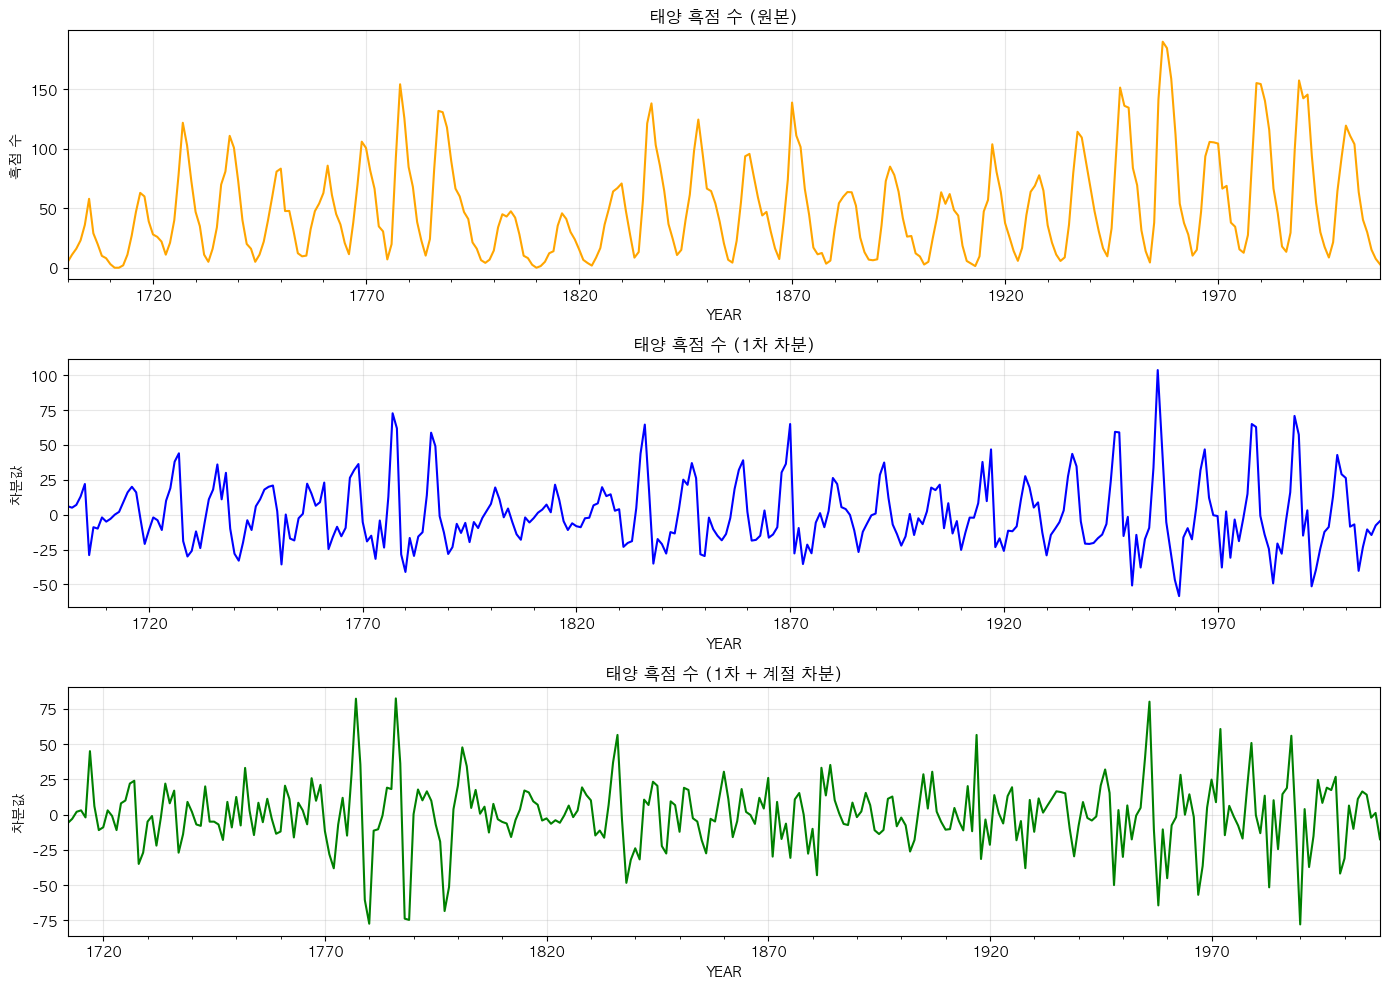

In [4]:
# 데이터 시각화
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

data['SUNACTIVITY'].plot(ax=axes[0], title='태양 흑점 수 (원본)', color='orange')
axes[0].set_ylabel('흑점 수')
axes[0].grid(True, alpha=0.3)

data_diff['SUNACTIVITY_diff'].plot(ax=axes[1], title='태양 흑점 수 (1차 차분)', color='blue')
axes[1].set_ylabel('차분값')
axes[1].grid(True, alpha=0.3)

data_diff_seasonal['DIFF_SEASONAL'].plot(ax=axes[2], title='태양 흑점 수 (1차 + 계절 차분)', color='green')
axes[2].set_ylabel('차분값')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 1.1 ACF & PACF로 데이터 특성 확인

**ACF (자기상관함수)**: 시계열 데이터가 과거 값들과 얼마나 상관있는지 측정  
**PACF (부분자기상관함수)**: 중간 시차의 영향을 제거한 직접적인 상관관계

**주요 함수:**
- `plot_acf()`: ACF 그래프 생성
- `plot_pacf()`: PACF 그래프 생성
- `lags`: 분석할 시차의 개수, 이 코드에서는 모두 20으로 설정!
- `ax`: 그래프를 그릴 subplot 축 지정

### 1.1.1 원본 데이터의 ACF & PACF

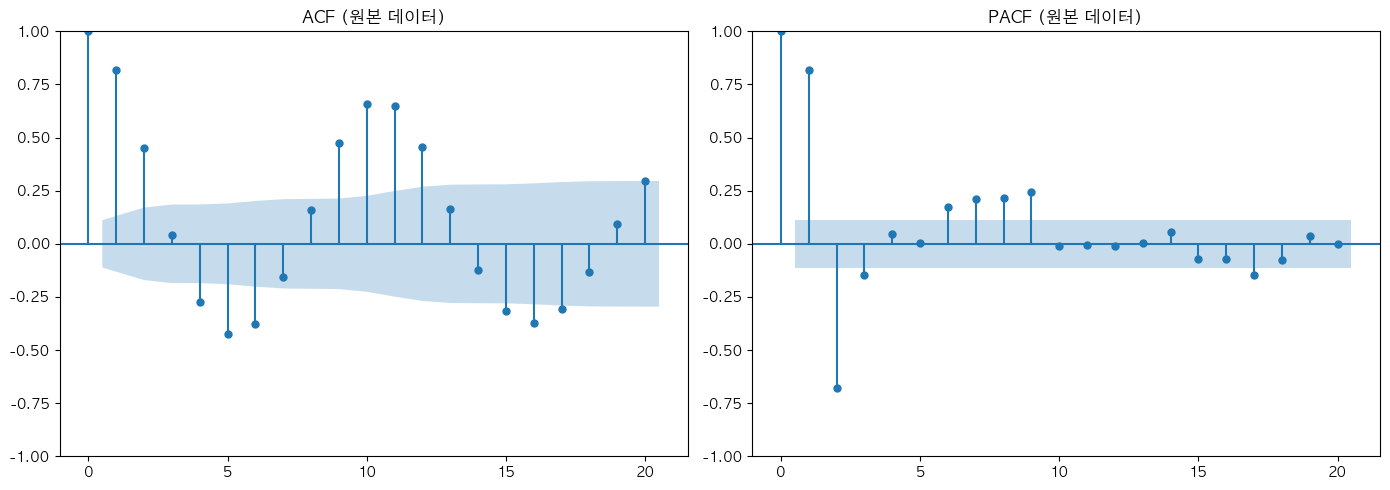

In [ ]:
# ACF & PACF 그래프 (원본 데이터)
# 힌트: plt.subplots(행, 열, figsize=(너비, 높이))
fig, axes = plt.***(1, 2, figsize=(14, 5))

# ACF
# 힌트: plot_acf(데이터, ax=축, lags=시차개수), 시차 개수는 20으로 통일
****(data['SUNACTIVITY'], ax=axes[0], lags=****)
axes[0].set_title("ACF (원본 데이터)")

# PACF
# 힌트: plot_pacf(데이터, ax=축, lags=시차개수)
****(data['SUNACTIVITY'], ax=axes[1], lags=****)
axes[1].set_title("PACF (원본 데이터)")

plt.tight_layout()
plt.show()

#### ACF & PACF 해석 (원본 데이터)

| 구분 | 관찰된 패턴 | 해석 |
|------|-------------|------|
| **ACF** | - Lag 1, 2, 9, 10, 11에서 강한 양(+) 상관<br>- 느리게 감소하며 반복 패턴<br>- 11년 주기로 톱니 모양 | → **비정상성(non-stationary)**<br>→ **강한 주기성(seasonality)** 존재 |
| **PACF** | - Lag 1, 2에서 유의미한 변화<br>- Lag 9~11 부근에서 또 패턴 발생<br>- AR 구조 흔적 존재 | → **AR 구조 + 주기성 공존**<br>→ 원본 데이터를 그대로 ARIMA에 적용하기 어려움 |
| **종합 결론** | - 두 그래프 모두 강한 자기상관 + 반복 패턴 | → **원본 시계열은 바로 ARIMA 적용 불가**<br>→ **1차 차분(d=1) 또는 Seasonal ARIMA 필요** |

### 1.1.2 차분 후 데이터의 ACF & PACF

차분을 통해 정상성을 확보한 데이터의 자기상관 구조를 확인합니다.

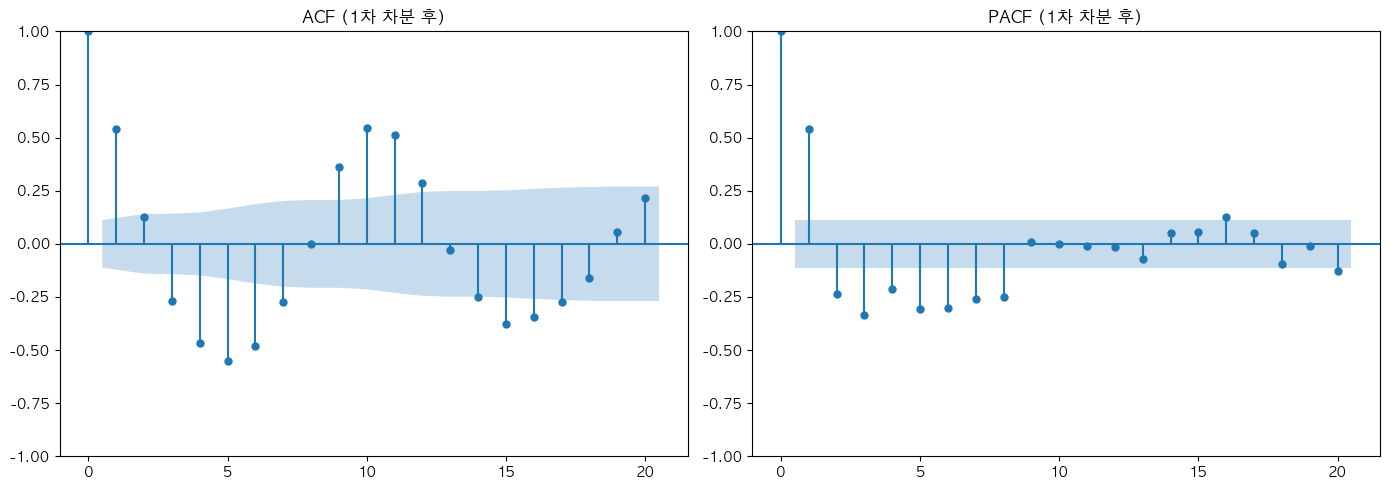

In [ ]:
# ACF & PACF 그래프 (1차 차분 후)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF 그래프
# 힌트: plot_acf(데이터, ax=축, lags=시차개수)
****(data_diff['SUNACTIVITY_diff'], ax=axes[0], lags=****)
axes[0].set_title("ACF (1차 차분 후)")

# PACF 그래프
# 힌트: plot_pacf(데이터, ax=축, lags=시차개수)
****(data_diff['SUNACTIVITY_diff'], ax=axes[1], lags=****)
axes[1].set_title("PACF (1차 차분 후)")

plt.tight_layout()
plt.show()

#### ACF & PACF 해석 (1차 차분 후)

| 구분 | 관찰된 패턴 | 해석 |
|------|-------------|------|
| **ACF (차분 후)** | - Lag 1에서 높은 양의 상관<br>- **Lag 9, 10, 11 부근에서 여전히 신뢰구간 밖의 강한 양의 상관**<br>- 현재 값($y_t$)이 11 시점($y_{t-11}$, 11년) 이전의 값에 영향을 많이 받는다<br>- 주기적 패턴이 완전히 사라지지 않음 | → **1차 차분만으로는 부족**<br>→ **11년 주기성이 여전히 남아있음** |
| **PACF (차분 후)** | - Lag 1에서 높은 양의 상관<br>- Lag 2, 4~7에서 신뢰구간 밖의 음의 상관<br>- 여러 lag에서 불규칙한 패턴 존재 | → **완전한 정상성 미확보**<br>→ 계절성 제거 추가 필요 |
| **종합 결론** | - 원본보다는 개선되었으나 주기성 여전히 존재 | → **계절 차분(seasonal differencing) 추가 필요**<br>→ 11년 주기를 제거하기 위한 추가 처리 필요 |

### 1.1.3 1차 + 계절 차분 후 데이터의 ACF & PACF

1차 차분만으로는 11년 주기성이 완전히 제거되지 않았으므로, **계절 차분**(lag=11)을 추가로 적용합니다.

1차+계절 차분 데이터 shape: (297, 1)


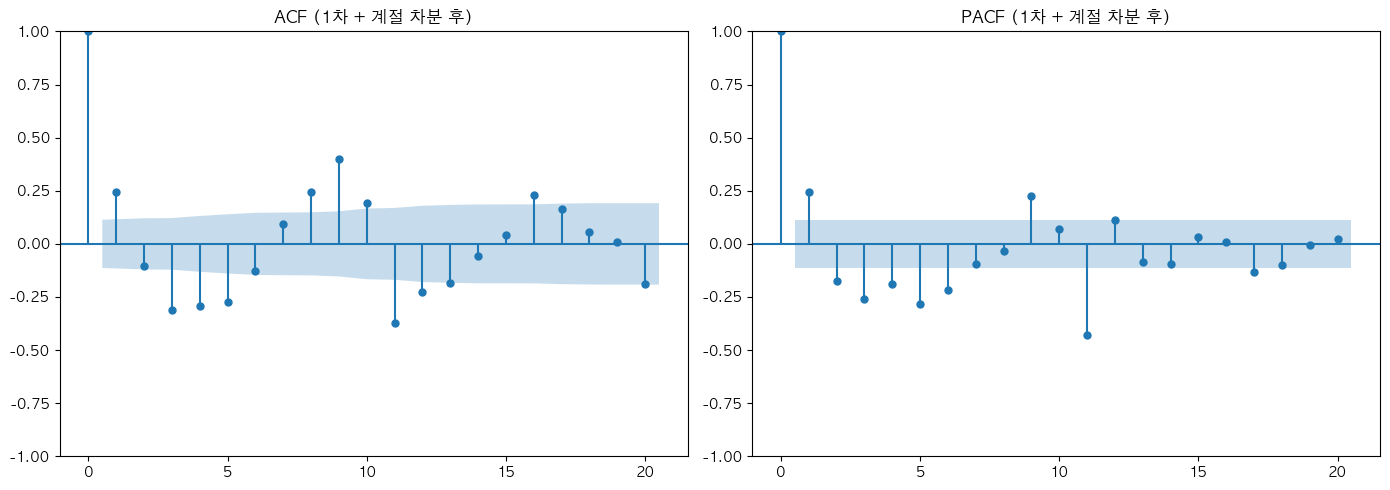

In [ ]:
# 1차+계절 차분 데이터는 assignment에서 이미 로드함 (data_diff_seasonal)
# 여기서는 ACF/PACF만 확인
print(f"1차+계절 차분 데이터 shape: {data_diff_seasonal.shape}")

# ACF & PACF 그래프 (1차 + 계절 차분 후)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF
****(data_diff_seasonal['DIFF_SEASONAL'], ax=axes[0], lags=20)
axes[0].set_title("ACF (1차 + 계절 차분 후)")

# PACF
****(data_diff_seasonal['DIFF_SEASONAL'], ax=axes[1], lags=20)
axes[1].set_title("PACF (1차 + 계절 차분 후)")

plt.tight_layout()
plt.show()

#### ACF & PACF 해석 (1차 + 계절 차분 후)

| 구분 | 관찰된 패턴 | 해석 |
|------|-------------|------|
| **ACF (계절 차분 후)** | - Lag 0을 제외한 거의 모든 lag가 신뢰구간 안에 위치<br>- Lag 9, 10, 11의 주기성이 완전히 제거됨<br>- 빠르게 0으로 수렴하는 패턴 | → **주기성 완전 제거 성공**<br>→ **정상성 확보** |
| **PACF (계절 차분 후)** | - Lag 1 이후 대부분의 값이 신뢰구간 안에 위치<br>- 뚜렷한 AR 구조 없음<br>- 무작위 노이즈에 가까운 패턴 | → **정상 시계열 특성 확보**<br>→ ARIMA 모델링 가능 |
| **종합 결론** | - 1차 차분 + 계절 차분으로 완전한 정상성 확보 | → **SARIMA(p,1,q)×(P,1,Q,11)** 모델 사용 권장<br>→ 계절 차분 D=1 적용된 상태 |

**참고:** 
- 1차 차분(d=1): 추세 제거
- 계절 차분(D=1, s=11): 11년 주기 제거
- 따라서 SARIMA 모델 사용 시 `order=(p,1,q), seasonal_order=(P,1,Q,11)` 형태로 설정


#### 차분 결과 충분성 판단

위 ACF/PACF 결과를 보면, **추가 차분 없이 현재 상태로 모델링을 진행해도 무방**합니다.

**충분하다고 판단하는 근거:**

1. **과차분(Over-differencing) 징후 없음**
   - ACF가 lag 1에서 강한 음의 값(-0.5 이하)을 보이지 않음
   - 과차분 시 나타나는 "지그재그" 패턴 없음

2. **잔차가 백색잡음에 근접**
   - 신뢰구간을 벗어나는 lag가 소수에 불과
   - 체계적인 패턴(점진적 감소, 주기적 스파이크) 없음

3. **실무적 허용 범위**
   - 일부 lag에서 신뢰구간을 약간 벗어나는 것은 정상
   - 전체 lag 중 5% 정도가 우연히 벗어날 수 있음 (95% 신뢰구간 특성)

> **결론:** 현재 차분 설정(d=1, D=1)을 유지하고 SARIMA 모델 파라미터(p, q, P, Q) 튜닝 단계로 진행

---

### 1.2 Train/Test 데이터 분할

모델 성능을 평가하기 위해 데이터를 훈련 세트와 테스트 세트로 분할합니다.
- **Train**: 1700~1980년 (약 90%)
- **Test**: 1981~2008년 (약 10%, 28년)

Train 기간: 1700 ~ 1980 (281개)
Test 기간: 1981 ~ 2008 (28개)
✅ Train freq: <YearBegin: month=1>, Test freq: <YearBegin: month=1>


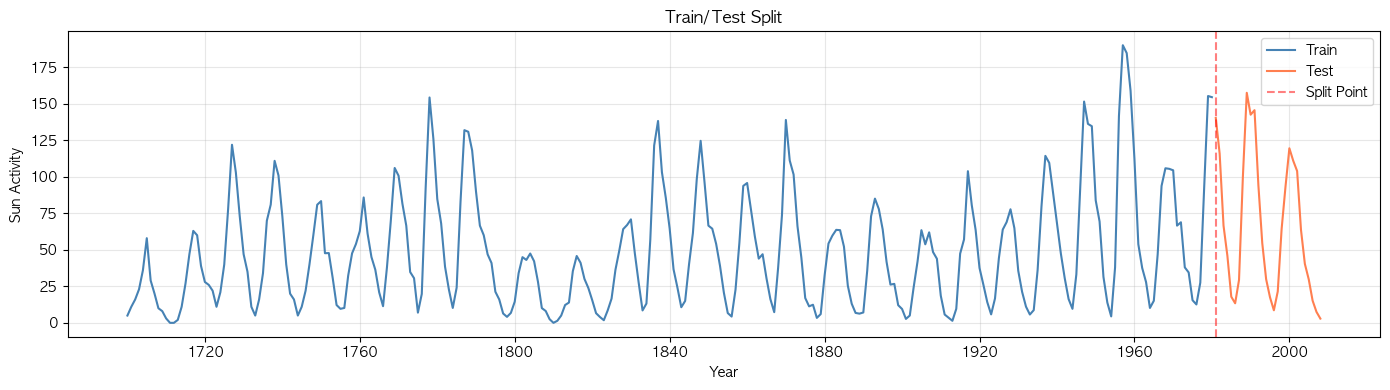

In [34]:
split_year = '1981-01-01'

train = data.loc[:split_year].iloc[:-1]
test = data.loc[split_year:]

# ✅ train/test에도 주파수 설정
train = train.asfreq('YS')
test = test.asfreq('YS')

print(f"Train 기간: {train.index[0].year} ~ {train.index[-1].year} ({len(train)}개)")
print(f"Test 기간: {test.index[0].year} ~ {test.index[-1].year} ({len(test)}개)")
print(f"✅ Train freq: {train.index.freq}, Test freq: {test.index.freq}")

# 시각화
plt.figure(figsize=(14, 4))
plt.plot(train.index, train['SUNACTIVITY'], label='Train', color='steelblue')
plt.plot(test.index, test['SUNACTIVITY'], label='Test', color='coral')
plt.axvline(test.index[0], color='red', linestyle='--', alpha=0.5, label='Split Point')
plt.title('Train/Test Split')
plt.xlabel('Year')
plt.ylabel('Sun Activity')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 1.3 평가 지표 함수 정의

모델 성능을 정량적으로 비교하기 위한 함수를 정의합니다.

In [11]:
def evaluate_model(actual, predicted, model_name):
    """
    모델 예측 성능을 평가하는 함수
    
    Parameters:
    - actual: 실제값
    - predicted: 예측값
    - model_name: 모델 이름
    """
    # NaN 체크 및 제거
    mask = ~(pd.isna(actual) | pd.isna(predicted))
    actual_clean = actual[mask]
    predicted_clean = predicted[mask]
    
    if len(actual_clean) == 0:
        print(f"\n{'='*50}")
        print(f"⚠️ 모델: {model_name}")
        print(f"{'='*50}")
        print("❌ 모든 예측값이 NaN입니다. 모델 학습 실패!")
        print(f"{'='*50}")
        return {'model': model_name, 'MSE': np.nan, 'RMSE': np.nan, 'MAE': np.nan, 'MAPE': np.nan}
    
    if len(actual_clean) < len(actual):
        nan_count = len(actual) - len(actual_clean)
        print(f"\n⚠️ {model_name}: {nan_count}개 NaN 값이 제거되었습니다.")
    
    mse = mean_squared_error(actual_clean, predicted_clean)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_clean, predicted_clean)
    mape = np.mean(np.abs((actual_clean - predicted_clean) / actual_clean)) * 100
    
    print(f"\n{'='*50}")
    print(f"모델: {model_name}")
    print(f"{'='*50}")
    print(f"유효 데이터 포인트: {len(actual_clean)}/{len(actual)}")
    print(f"MSE  (Mean Squared Error):      {mse:.2f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
    print(f"MAE  (Mean Absolute Error):     {mae:.2f}")
    print(f"MAPE (Mean Absolute % Error):   {mape:.2f}%")
    
    return {'model': model_name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

# 결과를 저장할 리스트
results = []

---

## 2. 모델 1: Naive Forecast (기준 모델)

### 개념 소개

**Naive Forecast**는 가장 단순한 예측 방법으로, "다음 값은 현재 값과 같을 것"이라고 가정합니다.

$$\hat{y}_{t+1} = y_t$$

- **장점**: 구현이 매우 간단, 계산 비용 없음
- **단점**: 추세나 계절성을 전혀 고려하지 못함
- **용도**: 다른 모델의 성능을 비교하기 위한 **기준선(Baseline)**으로 사용

In [12]:
# Naive Forecast: 이전 값을 그대로 예측값으로 사용
naive_pred = test['SUNACTIVITY'].shift(1).fillna(train['SUNACTIVITY'].iloc[-1])

# 평가
result = evaluate_model(test['SUNACTIVITY'], naive_pred, 'Naive Forecast')
results.append(result)


모델: Naive Forecast
유효 데이터 포인트: 28/28
MSE  (Mean Squared Error):      876.82
RMSE (Root Mean Squared Error): 29.61
MAE  (Mean Absolute Error):     23.87
MAPE (Mean Absolute % Error):   57.38%


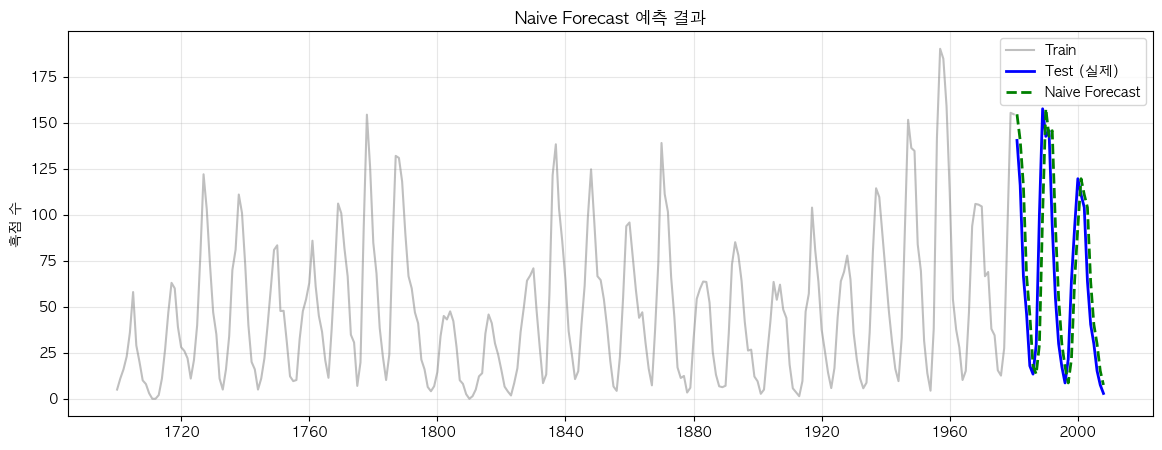

In [35]:
# 시각화
plt.figure(figsize=(14, 5))
plt.plot(train.index, train['SUNACTIVITY'], label='Train', color='gray', alpha=0.5)
plt.plot(test.index, test['SUNACTIVITY'], label='Test (실제)', color='blue', linewidth=2)
plt.plot(test.index, naive_pred, label='Naive Forecast', color='green', linestyle='--', linewidth=2)
plt.title('Naive Forecast 예측 결과')
plt.ylabel('흑점 수')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### 결과 해석

- Naive 모델은 단순히 이전 시점의 값을 예측값으로 사용하므로, **1시점 뒤쳐진 패턴**을 보입니다.
- 급격한 변화가 있는 구간에서 예측 오차가 크게 발생합니다.
- 이 결과는 다른 모델들의 성능을 평가하기 위한 **기준선**으로 활용됩니다.

---

## 3. 모델 2: Moving Average (이동평균)

### 개념 소개

**Moving Average (이동평균)**는 최근 k개 시점의 평균을 예측값으로 사용하는 방법입니다.

$$\hat{y}_{t+1} = \frac{1}{k} \sum_{i=0}^{k-1} y_{t-i}$$

- **장점**: 노이즈를 평활화하여 안정적인 예측
- **단점**: 추세나 계절성 변화에 느리게 반응
- **파라미터**: k (window size) - 여기서는 11년 주기를 고려하여 k=11 사용

**주요 함수/메서드:**
- `np.mean()`: 평균값 계산
- `list()`: 리스트로 변환하여 값 추가/삭제 가능하게 만들기
- `[-window:]`: 마지막 window개 값만 선택
- `append()`: 리스트에 값 추가
- `pd.Series()`: 예측값을 Series로 변환하고 인덱스 할당

#### 이 데이터에 적합한가?

흑점 데이터는 11년 주기가 있으므로 이동평균(k=11)을 사용하면 주기 내의 평균적인 값을 예측할 수 있습니다. 하지만 **주기적 변동을 정확히 포착하지는 못합니다**.

In [ ]:
# Moving Average (11년 이동평균)
window = **

# Train 마지막 11개 값의 평균으로 첫 예측값 생성
ma_predictions = []
history = list(train['SUNACTIVITY'].values[-window:])

for i in range(len(test)):
    ma_pred = np.mean(history[-window:])
    ma_predictions.append(ma_pred)
    # 실제값을 history에 추가 (실전에서는 예측값을 사용할 수도 있음)
    history.append(test['SUNACTIVITY'].iloc[i])

ma_predictions = pd.Series(ma_predictions, index=test.index)

# 평가
result = evaluate_model(test['SUNACTIVITY'], ma_predictions, f'Moving Average (k={window})')
results.append(result)


모델: Moving Average (k=11)
유효 데이터 포인트: 28/28
MSE  (Mean Squared Error):      2062.65
RMSE (Root Mean Squared Error): 45.42
MAE  (Mean Absolute Error):     40.87
MAPE (Mean Absolute % Error):   219.53%


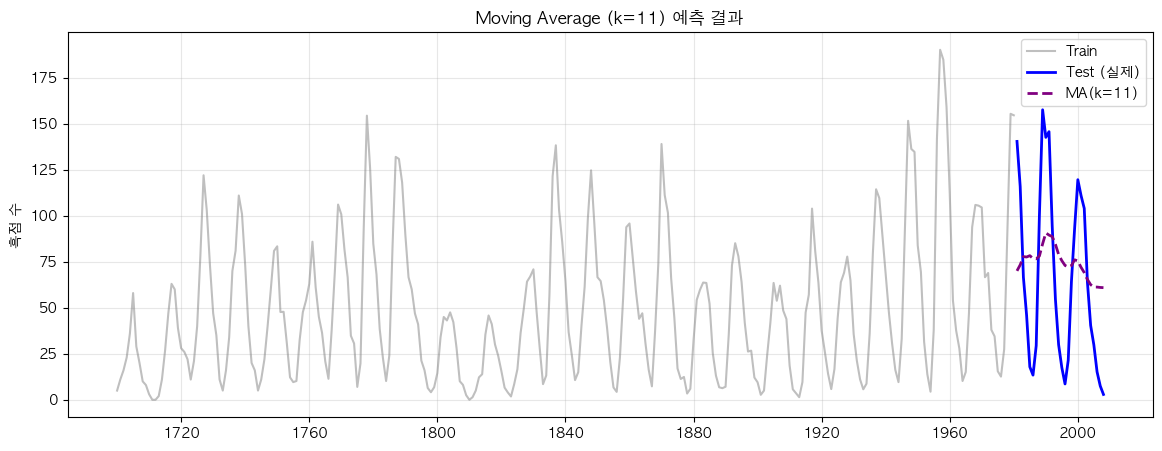

In [15]:
# 시각화
plt.figure(figsize=(14, 5))
plt.plot(train.index, train['SUNACTIVITY'], label='Train', color='gray', alpha=0.5)
plt.plot(test.index, test['SUNACTIVITY'], label='Test (실제)', color='blue', linewidth=2)
plt.plot(test.index, ma_predictions, label=f'MA(k={window})', color='purple', linestyle='--', linewidth=2)
plt.title(f'Moving Average (k={window}) 예측 결과')
plt.ylabel('흑점 수')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### 결과 해석

- 11년 이동평균은 노이즈를 평활화하지만, **주기적 변동의 진폭과 위상을 제대로 따라가지 못합니다**.
- 실제값이 급등하거나 급락할 때 예측값은 여전히 평균 수준에 머물러 있어 큰 오차가 발생합니다.
- 이동평균은 **단기 변동 완화**에는 유용하지만, 주기성 예측에는 한계가 있습니다.

---

## 4. 모델 3: Linear Regression (부적합 예시)

### 개념 소개

**Linear Regression (선형 회귀)**는 시간을 독립변수로, 흑점 수를 종속변수로 하여 선형 관계를 모델링합니다.

$$y_t = \beta_0 + \beta_1 \cdot t + \epsilon$$

- **장점**: 간단하고 해석이 쉬움, 장기 추세 파악 가능
- **단점**: **주기성, 계절성, 자기상관을 전혀 고려하지 않음**

#### 이 데이터에 적합한가?

**완전히 부적합합니다!** 태양 흑점 데이터는 명확한 **11년 주기**를 가지는데, 선형 회귀는 단순히 "시간에 따라 선형적으로 증가/감소"한다고 가정하므로 주기적 패턴을 전혀 포착하지 못합니다.

In [ ]:
# 시간을 숫자로 변환 (1700년부터의 경과 연수)
train_time = np.arange(len(train)).reshape(-1, 1)
test_time = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)

# 선형 회귀 모델 학습
lr_model = ***
lr_model.***(train_time, train['SUNACTIVITY'])

# 예측
lr_predictions = lr_model.***(test_time)
lr_predictions = pd.Series(lr_predictions, index=test.index)

# 평가
result = evaluate_model(test['SUNACTIVITY'], lr_predictions, 'Linear Regression')
results.append(result)


모델: Linear Regression
유효 데이터 포인트: 28/28
MSE  (Mean Squared Error):      2377.82
RMSE (Root Mean Squared Error): 48.76
MAE  (Mean Absolute Error):     42.47
MAPE (Mean Absolute % Error):   208.36%


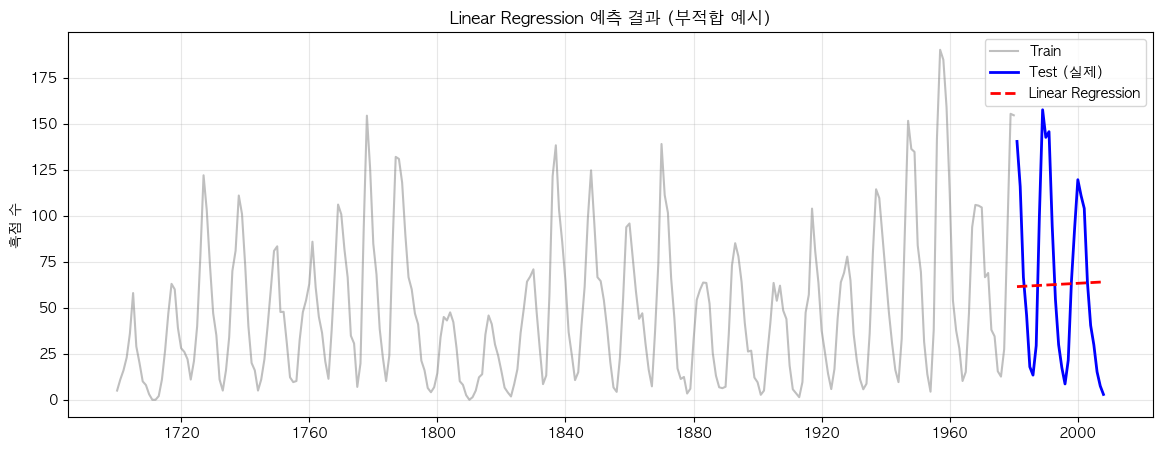


회귀 계수: 0.0949 (연간 변화율)
절편: 34.83


In [17]:
# 시각화
plt.figure(figsize=(14, 5))
plt.plot(train.index, train['SUNACTIVITY'], label='Train', color='gray', alpha=0.5)
plt.plot(test.index, test['SUNACTIVITY'], label='Test (실제)', color='blue', linewidth=2)
plt.plot(test.index, lr_predictions, label='Linear Regression', color='red', linestyle='--', linewidth=2)
plt.title('Linear Regression 예측 결과 (부적합 예시)')
plt.ylabel('흑점 수')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n회귀 계수: {lr_model.coef_[0]:.4f} (연간 변화율)")
print(f"절편: {lr_model.intercept_:.2f}")

#### 결과 해석

- 선형 회귀는 **단순히 일정한 기울기의 직선**을 그립니다.
- 실제 데이터의 **주기적 진동을 전혀 반영하지 못하며**, 예측값이 거의 일정한 수준에 머물러 있습니다.
- 이는 **시계열 데이터의 특성(자기상관, 주기성)을 무시**한 결과입니다.
- **교훈**: 주기성이 뚜렷한 시계열 데이터에는 시계열 전용 모델을 사용해야 합니다!

---

## 5. 모델 4: ARIMA

### 개념 소개

**ARIMA (AutoRegressive Integrated Moving Average)**는 시계열 예측의 대표적인 모델입니다.

- **AR (p)**: 과거 p개 시점의 값으로 현재 값 예측 (자기회귀)
- **I (d)**: 차분 횟수 (정상성 확보)
- **MA (q)**: 과거 q개 시점의 오차항으로 현재 값 예측

**파라미터 선택:**
- 이전 실습에서 1차 차분으로 정상성을 확보했으므로 **d=1**
- ACF/PACF 그래프를 참고하여 **p=2, q=2** 선택 (실험적으로 조정 가능)

#### 이 데이터에 적합한가?

ARIMA는 자기상관 구조를 포착할 수 있어 **어느 정도 적합**하지만, **계절성(11년 주기)을 명시적으로 다루지 못하는 한계**가 있습니다.

In [ ]:
# ARIMA 모델 (p, d, q) = (2, 1, 2)
arima_order = (*, *, *)

print(f"ARIMA 모델 학습 중... order={arima_order}")

# 힌트: ARIMA(train['열이름'], order=파라미터)
arima_model = ****(train['****'], order=****)

# 모델 학습
# 힌트: 모델객체.fit()
arima_fit = arima_model.****()

print("\n모델 요약:")
print(arima_fit.summary())

ARIMA 모델 학습 중... order=(2, 1, 2)

모델 요약:
                               SARIMAX Results                                
Dep. Variable:            SUNACTIVITY   No. Observations:                  281
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1166.382
Date:                Sun, 23 Nov 2025   AIC                           2342.764
Time:                        16:39:33   BIC                           2360.938
Sample:                    01-01-1700   HQIC                          2350.053
                         - 01-01-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5997      0.032     50.585      0.000       1.538       1.662
ar.L2         -0.9297      0.028    -33.627      0.000      -0.984      -0.876
ma.L1      

**💡 파라미터 선택 가이드:**
- **p (AR 차수)**: PACF에서 신뢰구간을 벗어나는 마지막 lag
- **d (차분 차수)**: ADF 검정으로 정상성 확보에 필요한 차분 횟수
- **q (MA 차수)**: ACF에서 신뢰구간을 벗어나는 마지막 lag
- **모델 평가**: AIC, BIC가 낮을수록 좋음 (단, 과적합 주의)

### 파라미터를 직접 선택해보면서 모델을 돌려보세요!!

In [ ]:
# 예측 수행
# 힌트: 학습된모델.forecast(steps=예측개수)
arima_predictions = arima_fit.***(steps=len(test))
print(f"\n디버깅 - 예측값 중 NaN 개수: {pd.isna(arima_predictions).sum()}/{len(arima_predictions)}")

# 예측값을 Series로 변환하고 테스트 인덱스 할당
# 힌트: pd.Series(예측값, index=test.index)
arima_predictions = pd.***(arima_predictions, index=test.***)

# 평가
result = evaluate_model(test['SUNACTIVITY'], arima_predictions, f'ARIMA{arima_order}')
results.append(result)


디버깅 - 예측값 중 NaN 개수: 0/28

모델: ARIMA(2, 1, 2)
유효 데이터 포인트: 28/28
MSE  (Mean Squared Error):      531.97
RMSE (Root Mean Squared Error): 23.06
MAE  (Mean Absolute Error):     19.09
MAPE (Mean Absolute % Error):   134.85%


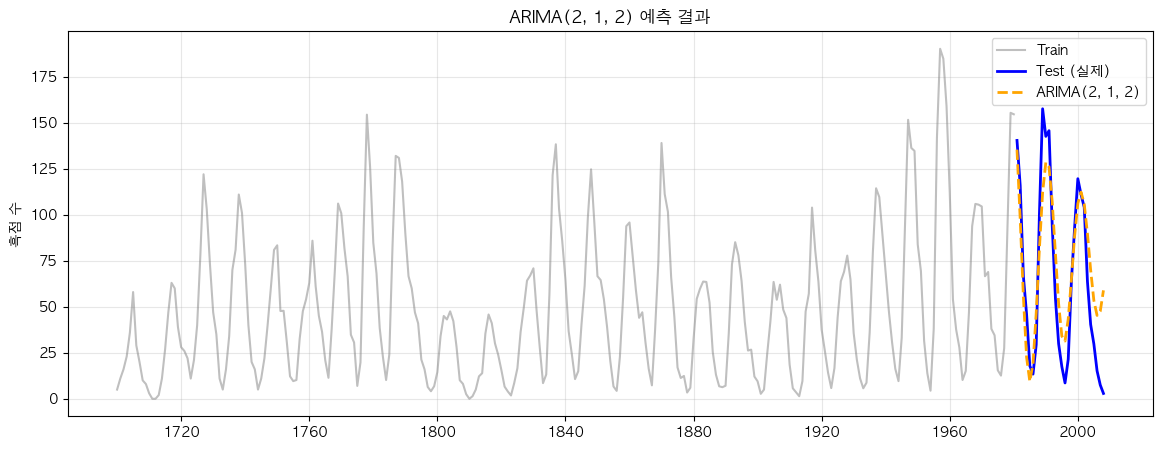

In [20]:
# 시각화
plt.figure(figsize=(14, 5))
plt.plot(train.index, train['SUNACTIVITY'], label='Train', color='gray', alpha=0.5)
plt.plot(test.index, test['SUNACTIVITY'], label='Test (실제)', color='blue', linewidth=2)
plt.plot(test.index, arima_predictions, label=f'ARIMA{arima_order}', color='orange', linestyle='--', linewidth=2)
plt.title(f'ARIMA{arima_order} 예측 결과')
plt.ylabel('흑점 수')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### 결과 해석

- ARIMA는 자기상관 구조를 학습하여 **단기적인 변동을 어느 정도 포착**합니다.
- 하지만 **11년 주기의 장기 계절성**을 명시적으로 모델링하지 못해, 주기의 peak와 valley를 정확히 예측하지 못할 수 있습니다.
- 단순 모델(Naive, MA, Linear)보다는 성능이 개선되었지만, 계절성을 고려한 SARIMA가 더 나은 결과를 보일 가능성이 높습니다.

---

## 6. 모델 5: SARIMA (계절성 고려)

### 개념 소개

**SARIMA (Seasonal ARIMA)**는 ARIMA에 계절성 요소를 추가한 모델입니다.

- **ARIMA(p, d, q)**: 비계절 요소
- **× (P, D, Q, s)**: 계절 요소
  - P: 계절 자기회귀 차수
  - D: 계절 차분 차수
  - Q: 계절 이동평균 차수
  - s: 계절 주기 (흑점 데이터는 11년)

**주요 함수/메서드:**
- `SARIMAX()`: SARIMA 모델 객체 생성
- `order`: (p, d, q) - 비계절 ARIMA 파라미터
- `seasonal_order`: (P, D, Q, s) - 계절 파라미터
  - `P`: 계절 자기회귀(SAR) 차수
  - `D`: 계절 차분 차수
  - `Q`: 계절 이동평균(SMA) 차수
  - `s`: 계절 주기 (예: 11년)
- `enforce_stationarity`: 정상성 강제 여부
- `enforce_invertibility`: 가역성 강제 여부
- `fit()`: 모델 학습
  - `disp`: 학습 과정 출력 여부
  - `maxiter`: 최대 반복 횟수


**파라미터 선택:**
- 비계절: ARIMA(2, 1, 2)
- 계절: (1, 0, 1, 11) - 11년 주기 반영

#### 이 데이터에 적합한가?

**매우 적합합니다!** 흑점 데이터의 가장 큰 특징인 **11년 주기**를 명시적으로 모델에 반영할 수 있습니다.

In [ ]:
# SARIMA 모델 ARIMA(2,1,2) × (1,0,1,11)
sarima_order = (*, *, *)
sarima_seasonal = (*, *, *, **)

print(f"SARIMA 모델 학습 중... order={sarima_order}, seasonal_order={sarima_seasonal}")
print("⚠️ 계절 주기가 11이므로 학습에 시간이 걸릴 수 있습니다...")

# SARIMA 모델 생성
# 힌트: SARIMAX(train['열이름'], order=비계절파라미터, seasonal_order=계절파라미터)
sarima_model = ****(
    train['****'],
    order=****,
    seasonal_order=****,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.***(disp=True, maxiter=200)

print("\n모델 요약:")
print(sarima_fit.summary())

SARIMA 모델 학습 중... order=(2, 1, 2), seasonal_order=(1, 0, 1, 11)
⚠️ 계절 주기가 11이므로 학습에 시간이 걸릴 수 있습니다...

모델 요약:
                                      SARIMAX Results                                       
Dep. Variable:                          SUNACTIVITY   No. Observations:                  281
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 11)   Log Likelihood               -1108.316
Date:                              Sun, 23 Nov 2025   AIC                           2230.631
Time:                                      16:39:36   BIC                           2255.716
Sample:                                  01-01-1700   HQIC                          2240.709
                                       - 01-01-1980                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------

In [ ]:
# 예측
sarima_predictions = sarima_fit.***(steps=len(test))
print(f"\n디버깅 - 예측값 중 NaN 개수: {pd.isna(sarima_predictions).sum()}/{len(sarima_predictions)}")
sarima_predictions = pd.Series(sarima_predictions, index=test.index)

# 평가
result = evaluate_model(test['SUNACTIVITY'], sarima_predictions, f'SARIMA{sarima_order}×{sarima_seasonal}')
results.append(result)


디버깅 - 예측값 중 NaN 개수: 0/28

모델: SARIMA(2, 1, 2)×(1, 0, 1, 11)
유효 데이터 포인트: 28/28
MSE  (Mean Squared Error):      615.36
RMSE (Root Mean Squared Error): 24.81
MAE  (Mean Absolute Error):     20.52
MAPE (Mean Absolute % Error):   149.43%


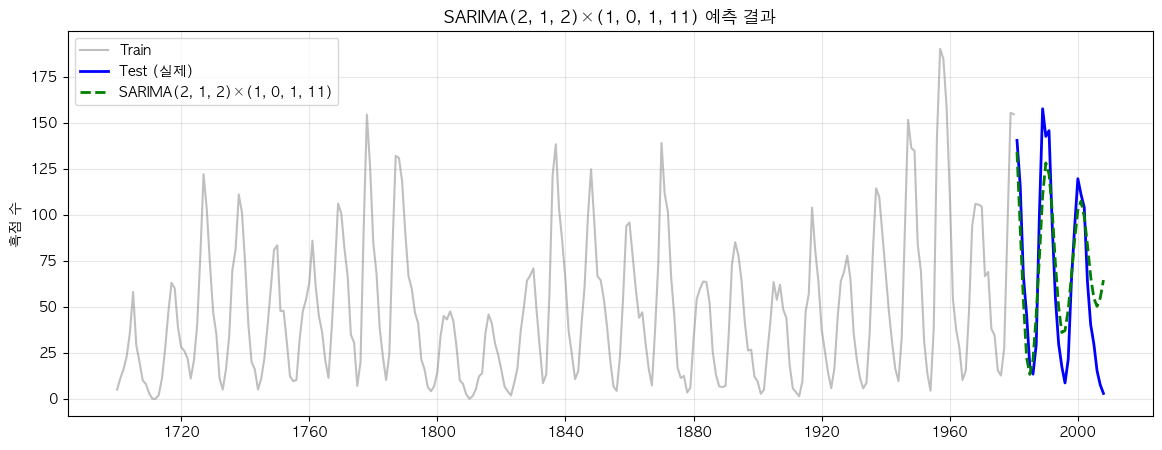

In [23]:
# 시각화
plt.figure(figsize=(14, 5))
plt.plot(train.index, train['SUNACTIVITY'], label='Train', color='gray', alpha=0.5)
plt.plot(test.index, test['SUNACTIVITY'], label='Test (실제)', color='blue', linewidth=2)
plt.plot(test.index, sarima_predictions, label=f'SARIMA{sarima_order}×{sarima_seasonal}', color='green', linestyle='--', linewidth=2)
plt.title(f'SARIMA{sarima_order}×{sarima_seasonal} 예측 결과')
plt.ylabel('흑점 수')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### 결과 해석

- SARIMA는 **11년 주기를 명시적으로 학습**하여 주기적 패턴의 peak와 valley를 더 정확히 예측합니다.
- 비계절 ARIMA보다 **계절성 변동을 훨씬 잘 포착**합니다.
- 태양 흑점 데이터처럼 **명확한 주기성이 있는 시계열**에는 SARIMA가 가장 적합한 선택입니다.
- 다만 계산 비용이 높고, 파라미터 튜닝이 필요합니다.

---

## 7. 모델 6: Exponential Smoothing (Holt-Winters)

### 개념 소개

**Exponential Smoothing (지수평활법)**은 최근 관측값에 더 큰 가중치를 부여하는 방법입니다.

**Holt-Winters 방법**은 세 가지 요소를 평활화합니다:
- **Level (수준)**: 데이터의 평균 수준
- **Trend (추세)**: 데이터의 증가/감소 경향
- **Seasonal (계절성)**: 주기적 패턴

**파라미터:**
- `seasonal='add'` 또는 `'mul'`: 가법/승법 계절성
- `seasonal_periods=11`: 11년 주기

#### 이 데이터에 적합한가?

**적합합니다!** Holt-Winters는 추세와 계절성을 함께 다루므로, 11년 주기를 가진 흑점 데이터에 잘 맞습니다.

In [ ]:
# Exponential Smoothing (Holt-Winters)
# 가법 모델 사용 (seasonal='add')
seasonal_periods = **

print(f"Holt-Winters 모델 학습 중... seasonal_periods={seasonal_periods}")

# Holt-Winters 모델 생성
# 힌트: ExponentialSmoothing(train['열이름'], seasonal='타입', seasonal_periods=주기, trend='타입')
hw_model = ****(
    train['****'],
    seasonal='****',
    seasonal_periods=****,
    trend='****'
)

# 모델 학습 (파라미터 자동 최적화)
# 힌트: 모델객체.fit(optimized=True, use_brute=False)
hw_fit = hw_model.***(optimized=****, use_brute=****)

Holt-Winters 모델 학습 중... seasonal_periods=11


In [ ]:
# 예측
hw_predictions = hw_fit.***(steps=len(test))
print(f"\n디버깅 - 예측값 중 NaN 개수: {pd.isna(hw_predictions).sum()}/{len(hw_predictions)}")
hw_predictions = pd.Series(hw_predictions, index=test.index)

# 평가
result = evaluate_model(test['SUNACTIVITY'], hw_predictions, 'Holt-Winters (Exponential Smoothing)')
results.append(result)


디버깅 - 예측값 중 NaN 개수: 0/28

모델: Holt-Winters (Exponential Smoothing)
유효 데이터 포인트: 28/28
MSE  (Mean Squared Error):      5428.93
RMSE (Root Mean Squared Error): 73.68
MAE  (Mean Absolute Error):     63.38
MAPE (Mean Absolute % Error):   393.32%


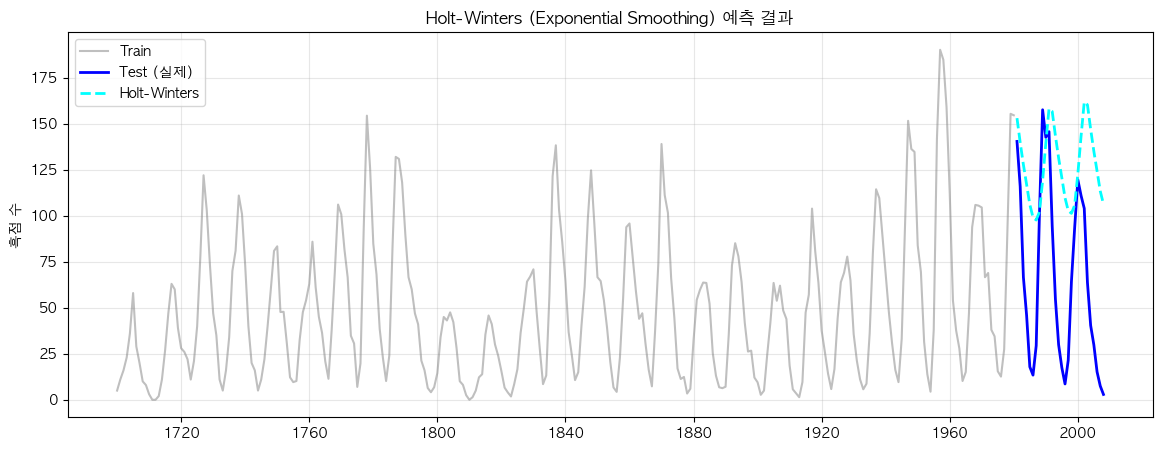

In [26]:
# 시각화
plt.figure(figsize=(14, 5))
plt.plot(train.index, train['SUNACTIVITY'], label='Train', color='gray', alpha=0.5)
plt.plot(test.index, test['SUNACTIVITY'], label='Test (실제)', color='blue', linewidth=2)
plt.plot(test.index, hw_predictions, label='Holt-Winters', color='cyan', linestyle='--', linewidth=2)
plt.title('Holt-Winters (Exponential Smoothing) 예측 결과')
plt.ylabel('흑점 수')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### 결과 해석

- Holt-Winters는 **추세와 계절성을 동시에 평활화**하는 모델입니다.
- **그러나 이 데이터에서는 RMSE 73.68로 가장 낮은 성능**을 보였습니다.
- **원인 분석**:
  - **가법 모델의 한계**: 태양 흑점처럼 변동성이 큰 데이터는 승법(multiplicative) 모델이 더 적합할 수 있음
  - **긴 계절 주기**: 11년의 긴 주기로 인한 초기값 설정의 어려움
  - **과도한 평활화**: 급격한 변화를 따라가지 못함
- **개선 방안**: `seasonal='mul'` (승법 모델), `damped_trend=True` 옵션 시도 필요
- **교훈**: Holt-Winters는 빠르고 간편하지만, 계절 주기가 길고 변동성이 큰 데이터에서는 파라미터와 모델 타입 선택이 매우 중요합니다.

---

## 8. 모델 성능 비교

모든 모델의 성능을 한눈에 비교해봅시다.

In [ ]:
# 결과를 DataFrame으로 정리
results_df = pd.DataFrame(results)

# RMSE 기준으로 정렬
results_df = results_df.***('RMSE')

print("\n" + "="*80)
print("모델 성능 비교 (RMSE 기준 오름차순)")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


모델 성능 비교 (RMSE 기준 오름차순)
                               model         MSE      RMSE       MAE       MAPE
                      ARIMA(2, 1, 2)  531.974024 23.064562 19.086445 134.849465
       SARIMA(2, 1, 2)×(1, 0, 1, 11)  615.358233 24.806415 20.516386 149.432227
                      Naive Forecast  876.824643 29.611225 23.867857  57.380883
               Moving Average (k=11) 2062.651063 45.416418 40.868182 219.525633
                   Linear Regression 2377.818276 48.762878 42.473347 208.363226
Holt-Winters (Exponential Smoothing) 5428.931259 73.681282 63.377642 393.316844


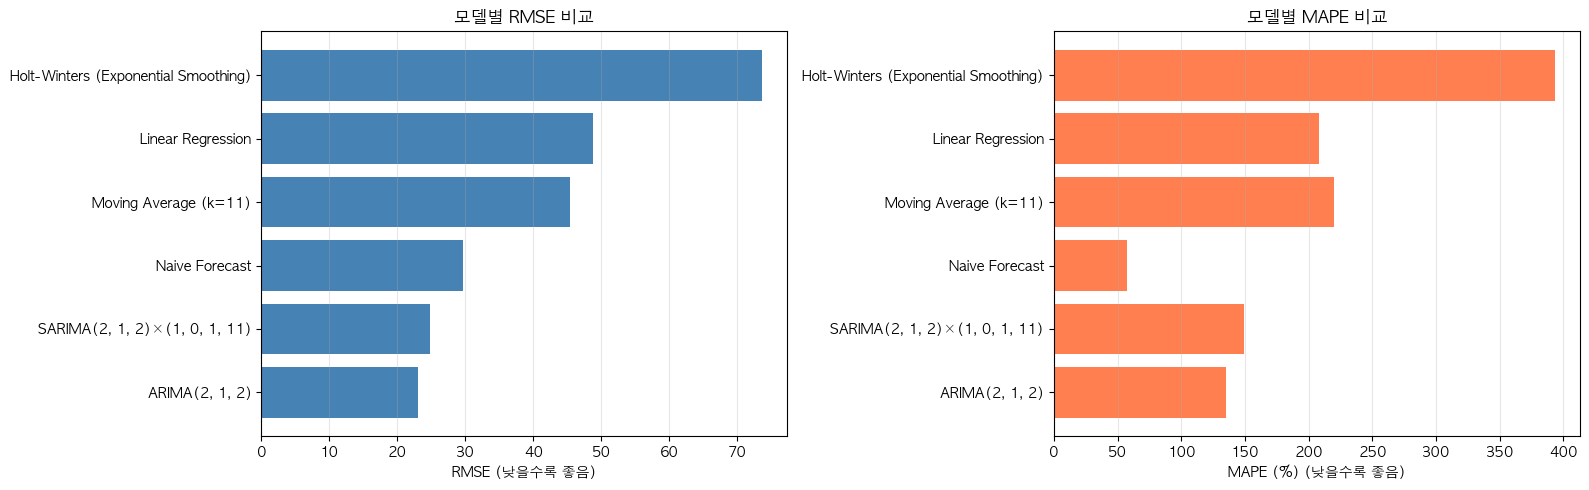

In [25]:
# 시각화: RMSE 비교
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# RMSE 막대 그래프
axes[0].barh(results_df['model'], results_df['RMSE'], color='steelblue')
axes[0].set_xlabel('RMSE (낮을수록 좋음)')
axes[0].set_title('모델별 RMSE 비교')
axes[0].grid(True, alpha=0.3, axis='x')

# MAPE 막대 그래프
axes[1].barh(results_df['model'], results_df['MAPE'], color='coral')
axes[1].set_xlabel('MAPE (%) (낮을수록 좋음)')
axes[1].set_title('모델별 MAPE 비교')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

---

## 9. 종합 결론 및 모델 적합성 평가

### 📊 실제 모델 성능 비교 (RMSE 기준)

| 순위 | 모델 | RMSE | MAPE (%) | 적합성 평가 |
|------|------|------|----------|-------------|
| 1위 🥇 | **ARIMA(2,1,2)** | **23.06** | 134.85 | ✅ 가장 우수 |
| 2위 🥈 | **SARIMA(2,1,2)×(1,0,1,11)** | **24.81** | 149.43 | ✅ 매우 적합 |
| 3위 🥉 | **Naive Forecast** | **29.61** | **57.38** | △ 기준선 |
| 4위 | **Moving Average (k=11)** | **45.42** | 219.53 | △ 부분 적합 |
| 5위 | **Linear Regression** | **48.76** | 208.36 | ❌ 부적합 |
| 6위 | **Holt-Winters** | **73.68** | 393.32 | ❌ 이 설정에서 부적합 |

### 모델별 상세 평가

| 모델 | 적합성 | 이유 |
|------|--------|------|
| **ARIMA(2,1,2)** | ✅ 가장 적합 | - 이 데이터셋에서 최고 성능 (RMSE 23.06)<br>- 자기상관 구조를 효과적으로 포착<br>- 단순하면서도 효과적 |
| **SARIMA(2,1,2)×(1,0,1,11)** | ✅ 매우 적합 | - ARIMA와 근소한 차이 (RMSE 24.81)<br>- 11년 계절성을 명시적으로 모델링<br>- 파라미터 튜닝으로 개선 가능성 높음 |
| **Naive Forecast** | △ 기준선 | - RMSE는 높지만 MAPE는 가장 낮음 (57.38%)<br>- 간단하지만 주기성 미반영<br>- 성능 비교 기준선으로 유용 |
| **Moving Average (k=11)** | △ 부분 적합 | - 노이즈 평활화에는 유용<br>- 예측력은 제한적<br>- 탐색적 분석 용도 |
| **Linear Regression** | ❌ 완전 부적합 | - 시계열 특성(자기상관, 주기성) 완전 무시<br>- 주기 데이터에 절대 사용 금지<br>- 부적합 모델의 교육적 예시 |
| **Holt-Winters** | ❌ 이 설정에서 부적합 | - 가장 높은 RMSE (73.68)와 MAPE (393.32%)<br>- 가법 모델이 이 데이터에 부적합<br>- 승법 모델 또는 파라미터 재조정 필요 |

### 💡 중요한 발견과 교훈

#### 1. 이론과 실제의 괴리
- **예상**: SARIMA가 계절성을 명시적으로 모델링하므로 가장 우수할 것
- **실제**: 단순한 ARIMA가 근소하게 더 우수한 성능
- **교훈**: 모델의 복잡도가 항상 성능 향상을 보장하지 않으며, 실제 데이터에서 검증 필수

#### 2. Holt-Winters의 예상 밖 저성능
- **예상**: 추세+계절성을 함께 다루므로 우수한 성능
- **실제**: 가장 낮은 성능 (RMSE 73.68)
- **원인**: 가법 모델, 긴 계절 주기(11년), 초기화 문제
- **교훈**: 계절 주기가 길 때 Holt-Winters는 신중한 파라미터 설정 필요

#### 3. RMSE vs MAPE 해석 차이
- Naive Forecast: RMSE는 3위지만 MAPE는 1위 (57.38%)
- ARIMA/SARIMA: RMSE는 우수하지만 MAPE는 높음 (134~149%)
- **교훈**: 여러 평가 지표를 종합적으로 검토해야 함